# Prerequisites
```
pip install clipper_admin==0.4.1 \
            torch==1.0.1 \
            torchvision==0.2.2 \
            numpy==1.16.4 \
            pandas==0.24.2 \
            pillow==6.0.0
```

In [1]:
!conda list |grep -i torch

torch                     1.0.1.post2               <pip>
torchvision               0.2.2.post3               <pip>


# Load a pretrained PyTorch model(ResNet50)

In [2]:
from torchvision.models.resnet import resnet50

In [3]:
model = resnet50(pretrained=True)

# Initialize the Clipper cluster

In [4]:
from clipper_admin import ClipperConnection, DockerContainerManager

In [5]:
clipper_conn = ClipperConnection(DockerContainerManager())

In [6]:
clipper_conn.start_clipper(cache_size=1)  # Disable PredictionCache

19-06-09:01:18:13 INFO     [docker_container_manager.py:184] [default-cluster] Starting managed Redis instance in Docker
19-06-09:01:18:16 INFO     [docker_container_manager.py:276] [default-cluster] Metric Configuration Saved at /private/var/folders/3q/f41dn1j54z72yf8bs2_80l1r0000gn/T/tmpm_qp9p3d.yml
19-06-09:01:18:17 INFO     [clipper_admin.py:162] [default-cluster] Clipper is running


In [7]:
!docker ps -a

CONTAINER ID        IMAGE                               COMMAND                  CREATED             STATUS                  PORTS                                            NAMES
d208e4f8249f        prom/prometheus:v2.9.2              "/bin/prometheus --c…"   1 second ago        Up Less than a second   0.0.0.0:9090->9090/tcp                           metric_frontend-16880
7e4450beacac        clipper/frontend-exporter:0.4.1     "python /usr/src/app…"   2 seconds ago       Up 1 second                                                              query_frontend_exporter-51535
2ee263c0e46c        clipper/query_frontend:0.4.1        "/clipper/query_fron…"   3 seconds ago       Up 1 second             0.0.0.0:1337->1337/tcp, 0.0.0.0:7000->7000/tcp   query_frontend-51535
a4031b397665        clipper/management_frontend:0.4.1   "/clipper/mgmt_front…"   3 seconds ago       Up 2 seconds            0.0.0.0:1338->1338/tcp                           mgmt_frontend-51592
ad5a549d6560        redis:alpin

# Define 'predict' function

In [8]:
import io
from PIL import Image
from torch.autograd import Variable
import torchvision.transforms as transforms

# Imported from https://gist.github.com/jkarimi91/d393688c4d4cdb9251e3f939f138876e.
   
min_img_size = 224
transform_pipeline = transforms.Compose([transforms.Resize(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])

def predict(model, inputs):
    def _predict_one(one_input_arr):
        try:
            img = Image.open(io.BytesIO(one_input_arr))
            if img.mode != "RGB":
                img = img.convert("RGB")
            img = transform_pipeline(img)
            img = img.unsqueeze(0)
            img = Variable(img)
            return [model(img).data.numpy().argmax()]
        except Exception as e:
            print(e)
            return []
        
    return [_predict_one(i) for i in inputs]

# Deploy PyTorch model and 'predict' function to the Clipper cluster

In [9]:
import clipper_admin.deployers.pytorch as pytorch_deployer

In [10]:
app_name = 'pytorch-test-app'
model_name = 'pytorch-test-model'

In [11]:
pytorch_deployer.deploy_pytorch_model(clipper_conn=clipper_conn,
                                      name=model_name,
                                      version='1',
                                      input_type='bytes',
                                      func=predict,
                                      pytorch_model=model,
                                      num_replicas=1,
                                      batch_size=1,  # Disable adaptive batching policy
                                      pkgs_to_install=['pillow'])

19-06-09:01:18:17 INFO     [deployer_utils.py:41] Saving function to /var/folders/3q/f41dn1j54z72yf8bs2_80l1r0000gn/T/tmps1rdkwrsclipper
19-06-09:01:18:17 INFO     [deployer_utils.py:51] Serialized and supplied predict function
19-06-09:01:18:18 INFO     [pytorch.py:204] Torch model saved
19-06-09:01:18:18 INFO     [pytorch.py:218] Using Python 3.6 base image
19-06-09:01:18:18 INFO     [clipper_admin.py:534] [default-cluster] Building model Docker image with model data from /var/folders/3q/f41dn1j54z72yf8bs2_80l1r0000gn/T/tmps1rdkwrsclipper
19-06-09:01:18:23 INFO     [clipper_admin.py:539] [default-cluster] Step 1/3 : FROM clipper/pytorch36-container:0.4.1
19-06-09:01:18:23 INFO     [clipper_admin.py:539] [default-cluster]  ---> e3c73c7ad6b9
19-06-09:01:18:23 INFO     [clipper_admin.py:539] [default-cluster] Step 2/3 : RUN apt-get -y install build-essential && pip install pillow
19-06-09:01:18:23 INFO     [clipper_admin.py:539] [default-cluster]  ---> Using cache
19-06-09:01:18:23 INFO

In [12]:
clipper_conn.register_application(name=app_name,
                                  input_type="bytes",
                                  default_output="-1.0",
                                  slo_micros=10000000)  # 10s

19-06-09:01:18:27 INFO     [clipper_admin.py:236] [default-cluster] Application pytorch-test-app was successfully registered


In [13]:
clipper_conn.link_model_to_app(app_name=app_name,
                               model_name=model_name)

19-06-09:01:18:27 INFO     [clipper_admin.py:303] [default-cluster] Model pytorch-test-model is now linked to application pytorch-test-app


In [14]:
import time
time.sleep(30)

# Download sample images

In [15]:
!wget https://harishnarayanan.org/images/writing/artistic-style-transfer/output_13_0.png -O elephant.jpg

--2019-06-09 01:18:57--  https://harishnarayanan.org/images/writing/artistic-style-transfer/output_13_0.png
Resolving harishnarayanan.org (harishnarayanan.org)... 46.101.13.93
Connecting to harishnarayanan.org (harishnarayanan.org)|46.101.13.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111477 (109K) [image/png]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 108.86K   208KB/s    in 0.5s    

2019-06-09 01:18:59 (208 KB/s) - ‘elephant.jpg’ saved [111477/111477]



In [16]:
!wget http://kikei.github.io/images/plots/2018-08-05-rabbit2.jpg -O rabbit.jpg

--2019-06-09 01:18:59--  http://kikei.github.io/images/plots/2018-08-05-rabbit2.jpg
Resolving kikei.github.io (kikei.github.io)... 185.199.108.153, 185.199.109.153, 185.199.111.153, ...
Connecting to kikei.github.io (kikei.github.io)|185.199.108.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22976 (22K) [image/jpeg]
Saving to: ‘rabbit.jpg’

rabbit.jpg          100%[===================>]  22.44K  --.-KB/s    in 0.08s   

2019-06-09 01:19:00 (267 KB/s) - ‘rabbit.jpg’ saved [22976/22976]



In [17]:
from IPython.display import display
from PIL import Image

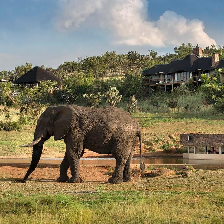

In [18]:
display(Image.open('elephant.jpg'))

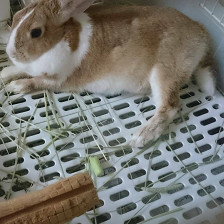

In [19]:
display(Image.open('rabbit.jpg'))

# Send some requests to the Clipper cluster

In [20]:
import json
import base64
import requests
from datetime import datetime

In [21]:
headers = {'Content-type': 'application/json'}
url = "http://{addr}/{app_name}/predict".format(
    addr=clipper_conn.get_query_addr(),
    app_name=app_name)

### First request, which is so slow due to downloading a file from https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json.

In [22]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('elephant.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [23]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":0,"output":[463],"default":false}', 608.707000 ms


### Second request, which is moderate!

In [24]:
start = datetime.now()
req_json = json.dumps({ "input": base64.b64encode(open('rabbit.jpg', "rb").read()).decode() })
r = requests.post(url, headers=headers, data=req_json)
end = datetime.now()

In [25]:
latency = (end - start).total_seconds() * 1000.0
print("'%s', %f ms" % (r.text, latency))

'{"query_id":1,"output":[463],"default":false}', 875.927000 ms


# Clean-up

In [26]:
clipper_conn.stop_all()

19-06-09:01:19:45 INFO     [clipper_admin.py:1424] [default-cluster] Stopped all Clipper cluster and all model containers


In [27]:
!docker rm -f $(docker ps -a -q) && docker image prune -f

79fd8b16a581
d208e4f8249f
7e4450beacac
2ee263c0e46c
a4031b397665
ad5a549d6560
Deleted Images:
deleted: sha256:a93000adc26ed0a4c976a6424cb04b78db6203f409d64e7cf50336ad41f5eef0
deleted: sha256:49a6d8dfa55d851477dd9d112f7b6ed82dd4da8dfc86a874fc9dd2a395c5d985

Total reclaimed space: 257.3MB
